In [2]:
# paperspace gradient用
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/notebooks/MOD2NN')

fatal: destination path 'MOD2NN' already exists and is not an empty directory.


In [1]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [1]:
import os
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer

## Create 1 layer model

In [2]:
#@title デフォルトのタイトル テキスト
wavelength = 633.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}
z = 0.1e-3 #@param {type:"number"}

def create_model(**kwargs):
    shape = (28, 28)
    theta = kwargs["theta"]
    eta = 0.
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = IntensityToElectricField(shape)(inputs)
    x = MO(shape, limitation=None, theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = ElectricFieldToIntensity(shape)(x)
    model = tf.keras.Model(inputs, x)
    return model

In [3]:
model = create_model(theta = np.pi/2, seed=1)
mo_layer = model.layers[2]

2022-10-31 10:40:45.797931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 10:40:45.798443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


## Input light distribution

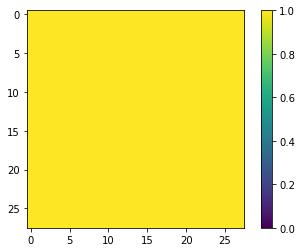

In [5]:
input = np.ones((1,28,28))
plt.imshow(input[0,:,:], vmin=0, vmax=1)
plt.colorbar()

## Target Output

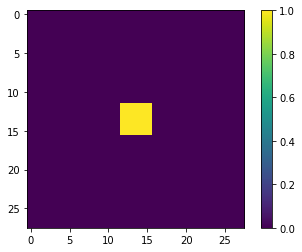

In [6]:
out = np.zeros_like(input)
out[:, 12:16, 12:16] = 1
plt.imshow(out[0,:,:], vmin=0, vmax=1)
plt.colorbar()

## MCMC
### initilize

In [7]:
weights = mo_layer.get_weights()
spins1 = weights[0]
spins1 = 2*np.random.binomial(1, 0.5, size=spins1.shape)- 1
nw_spins1 = spins1.copy()
MCDISC = 5
history = []
images = []

kb = 1
T = 1.0

$$
E=(I-I_{target})^2
$$
$$
\pi(x)=e^{-x/k_bT}
$$

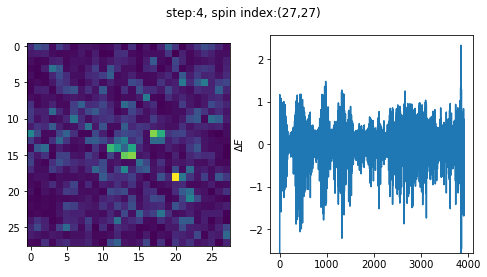

In [8]:
for MC in range(MCDISC):
    print(f'{MC}/{MCDISC}')

    for i in range(spins1.shape[0]):
        for j in range(spins1.shape[1]):
            pred1 = model.predict(input, verbose=0)
            pred1/np.max(pred1)
            E1 = np.sum((out-pred1[0])**2)

            nw_spin1 = -spins1[i,j]
            nw_spins1 = spins1.copy()
            nw_spins1[i, j] = nw_spin1
            weights[0] = nw_spins1
            mo_layer.set_weights(weights)

            pred2 = model.predict(input, verbose=0)
            pred2/np.max(pred2)
            Eg = np.sum((out-pred2[0])**2)

            dE = Eg-E1

            a = min(1, np.exp(-dE/(kb*T)))

            if np.random.rand() < a:
                spins1[i,j] = nw_spin1
                images.append(pred2[0])
            else:
                images.append(pred1[0])

            history.append(dE)
            history_std = np.std(history)

            display.clear_output(wait=True)
            fig = plt.figure(figsize=(8,4))
            fig.suptitle(f'step:{MC}, spin index:({i},{j})')
            plt.subplot(1,2,1)
            plt.imshow(images[-1])
            plt.subplot(1,2,2)
            plt.plot(history)
            plt.ylim(-history_std*2, history_std*2)
            plt.ylabel("$\Delta E$")
            plt.show()

In [47]:
len(images)

3920

In [102]:
import imageio
imageio.mimsave("mcstep2.gif", images, "GIF", **{'duration': 0.001})

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

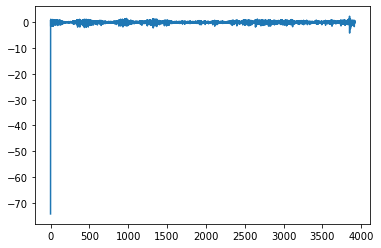

In [9]:
plt.plot(history)

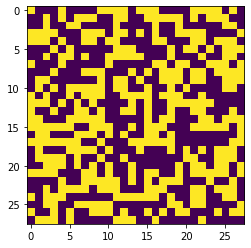

In [10]:
plt.imshow(spins1)

In [158]:
weights = mo_layer.get_weights()
spins1 = weights[0]
spins1 = 2*np.random.binomial(1, 0.5, size=spins1.shape)- 1
nw_spins1 = spins1.copy()
MCDISC = 1000
history = []
images = []

kb = 1
T = 1.0

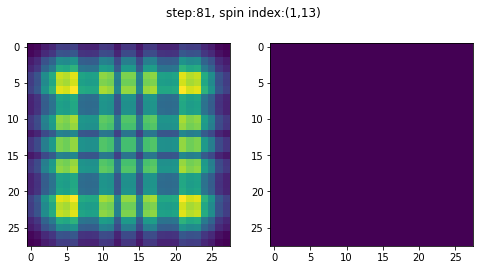

KeyboardInterrupt: 

In [162]:
for MC in range(MCDISC):
    pred1 = model.predict(input, verbose=0)
    pred1/np.max(pred1)
    E1 = np.sum((out-pred1[0])**2)

    nw_spins1 = -spins1.copy()
    weights[0] = nw_spins1
    mo_layer.set_weights(weights)
    pred2 = model.predict(input, verbose=0)
    pred2/np.max(pred2)
    E2 = np.sum((out-pred1[0])**2)

    dE = E2 - E1

    a = min(1, np.exp(-dE/(kb*T)))
    r = np.random.rand()
    if r < a:
        spins1 = nw_spins1 * 2*(np.random.binomial(1, a, size=spins1.shape))-1
        images.append(pred2[0])
    else:
        spins1 = nw_spins1 * 2*(np.random.binomial(1, 1-a, size=spins1.shape))-1
        images.append(pred1[0])


    display.clear_output(wait=True)
    fig = plt.figure(figsize=(8,4))
    fig.suptitle(f'step:{MC}, spin index:({i},{j})')
    plt.subplot(1,2,1)
    plt.imshow(images[-1])
    plt.subplot(1,2,2)
    plt.imshow(spins1, interpolation="none")
    plt.show()

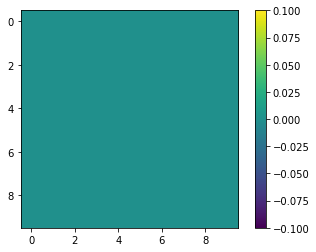

In [161]:
plt.imshow(np.random.binomial(1, 0, (10,10)))
plt.colorbar()